### Import Necessary Libraries

In [5]:
import tensorflow as tf
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array

In [6]:
import kagglehub

# download latest version
path = kagglehub.dataset_download("aibloy/fairface")

print("Path to dataset files:", path)
#print("Files in directory:", os.listdir(path+"/FairFace/train"))
# This project is inspired and based on https://github.com/varundixit4/Generating-Fake-Faces-Using-GAN github repo project
# and https://ar5iv.labs.arxiv.org/html/1803.04469 ("An Introduction to Image Synthesis with Generative Adversarial Nets" by He Huang, Philip S. Yu and Changhu Wang)

Path to dataset files: /root/.cache/kagglehub/datasets/aibloy/fairface/versions/1


# DataSet Visualization

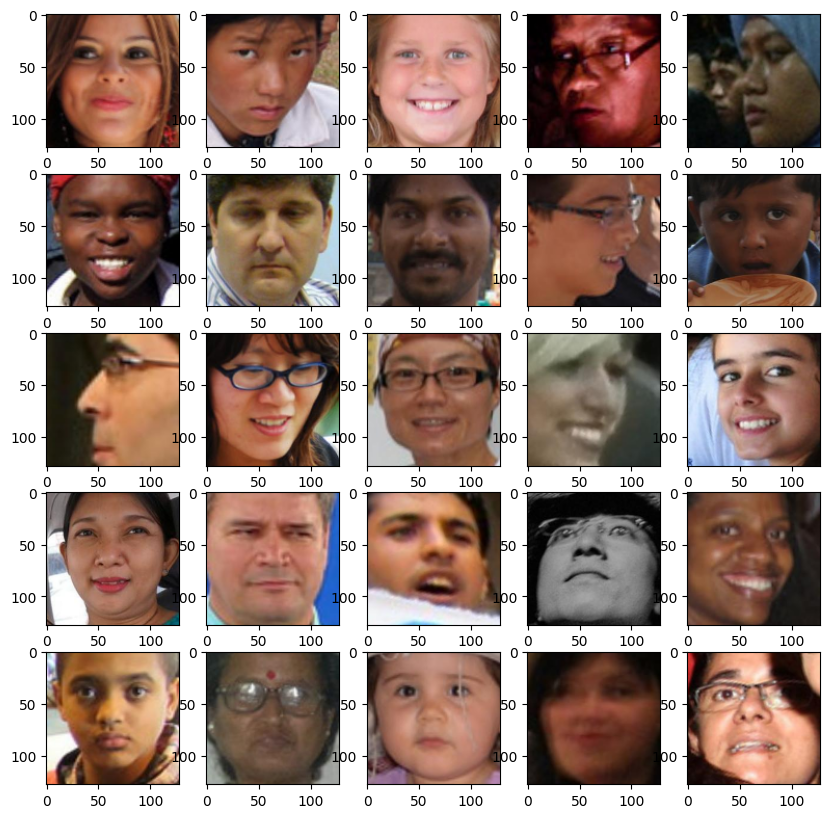

In [7]:
# get path to dataset
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

plot = plt.figure(figsize=(10,10))
columns = 5
rows = 5

path_of_imgs = path+"/FairFace/train"

# convert dataset to arrays
SIZE = 128
_img = []

# get a list of all image files in the directory
image_files = [os.path.join(path_of_imgs, f) for f in os.listdir(path_of_imgs) if os.path.isfile(os.path.join(path_of_imgs, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]
for i in range(500):
    img = mpimg.imread(image_files[i]) # read each image file
    img = cv2.resize(img, (SIZE, SIZE))
    imh = img.astype(float)
    _img.append(img_to_array(img))
    if i < columns * rows:
      plot.add_subplot(rows, columns, i + 1)
      plt.imshow(img) # display the image

plt.show()


In [8]:
# divide dataset by batch size
batch_size = 25
dataset=tf.data.Dataset.from_tensor_slices(np.array(_img)).batch(batch_size)
num_batches = tf.data.experimental.cardinality(dataset).numpy()

# Calculate the total number of pictures
total_pictures = num_batches * batch_size

print("Total number of pictures in the dataset:", total_pictures)
print("Number of photo in _img: ", len(_img))

Total number of pictures in the dataset: 500
Number of photo in _img:  500


## Generator

In [9]:
# generator function
latent_dim = 100
def Generator():
    model = tf.keras.Sequential([
        # input layer
        layers.Dense(128 * 128 * 3, use_bias=False, input_shape=(latent_dim,)),
        layers.Reshape((128, 128, 3)),

        # convolutional layers for feature extraction and refinement
        layers.Conv2D(128, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2D(256, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # upsampling to add detail and improve resolution
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh')
    ])

    return model

In [10]:
generator = Generator()
generator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 49152)               │       4,915,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 128)         │           6,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 256)         │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 64, 64, 128)         │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 128, 128, 3)         │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,978,115 (22.80 MB)

 Trainable params: 5,977,091 (22.80 MB)

 Non-trainable params: 1,024 (4.00 KB)

## Discriminator

In [11]:
# discriminator function
def Discriminator():
    model = tf.keras.Sequential([
        # input layer for the image
        layers.Input((SIZE, SIZE, 3)),

        # convolutional layers for feature extraction
        layers.Conv2D(128, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2D(256, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2D(512, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # flatten and classify as real or fake
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])

    return model

In [12]:
discriminator = Discriminator()
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │           6,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 256)         │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 512)         │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16, 16, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │         131,073 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,762,241 (10.54 MB)

 Trainable params: 2,760,449 (10.53 MB)

 Non-trainable params: 1,792 (7.00 KB)

### Plot Image Generated By Generator By Noise (before training)

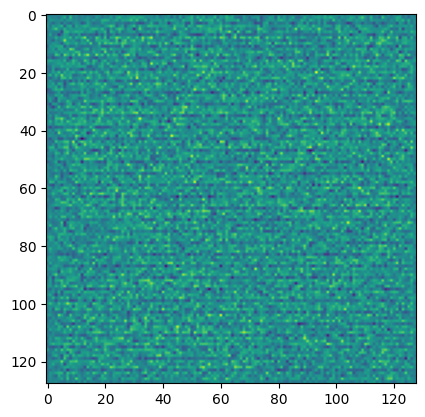

In [13]:
# plot image of generator
noise = np.random.normal(-1,1,(1,100))
img = generator(noise)
plt.imshow(img[0,:,:,0])
plt.show()

### Define Loss Function And Optimizer

In [14]:
# optimizers and cross entropy loss
generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001, clipvalue=1.0)
discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001, clipvalue=1.0)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)
def discriminator_loss(fake_output, real_output):
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    return fake_loss + real_loss

### Define Training Steps

In [16]:
# training steps function
def train_steps(images):
    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # generate fake images and discriminator outputs
        fake_images = generator(noise)
        fake_output = discriminator(fake_images)
        real_output = discriminator(images)

        # compute losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(fake_output, real_output)

    # compute and apply gradients
    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    return {'gen_loss': gen_loss, 'disc_loss': disc_loss}

### Function To Plot Generated Images


In [17]:
# plot generated image
def plot_generated_images(square = 5, epochs = 0):
  plt.figure(figsize = (10,10))
  for i in range(square * square):
    if epochs != 0:
        if(i == square //2):
            plt.title("Generated Image at Epoch:{}\n".format(epochs), fontsize = 32, color = 'black')
    plt.subplot(square, square, i+1)
    noise = np.random.normal(0,1,(1,latent_dim))
    img = generator(noise)
    plt.imshow(np.clip((img[0,...]+1)/2, 0, 1))

    plt.xticks([])
    plt.yticks([])
    plt.grid()

In [1]:
import time
# train by calling train_steps
def train(epochs, dataset):
    for epoch in range(epochs):
        start = time.time()
        print("\nEpoch: {}".format(epoch + 1))

        # track losses across the epoch
        total_gen_loss = 0
        total_disc_loss = 0
        batch_count = 0

        for images in dataset:
            loss = train_steps(images)
            total_gen_loss += loss['gen_loss']
            total_disc_loss += loss['disc_loss']
            batch_count += 1

        # calculate average loss
        avg_gen_loss = total_gen_loss / batch_count
        avg_disc_loss = total_disc_loss / batch_count

        # epoch summary
        print("Time: {:.2f} seconds".format(time.time() - start))
        print("Generator Loss: {:.4f}, Discriminator Loss: {:.4f}".format(avg_gen_loss, avg_disc_loss))

### Training

In [18]:
train(5, dataset)


Epoch: 1
Time: 381.99 seconds
Generator Loss: 1.0694, Discriminator Loss: 0.5881

Epoch: 2
Time: 381.91 seconds
Generator Loss: 1.4124, Discriminator Loss: 0.3397

Epoch: 3
Time: 354.93 seconds
Generator Loss: 1.5232, Discriminator Loss: 1.8143

Epoch: 4
Time: 381.91 seconds
Generator Loss: 2.6034, Discriminator Loss: 1.1190

Epoch: 5
Time: 340.56 seconds
Generator Loss: 2.6025, Discriminator Loss: 1.2353


## Generated Images


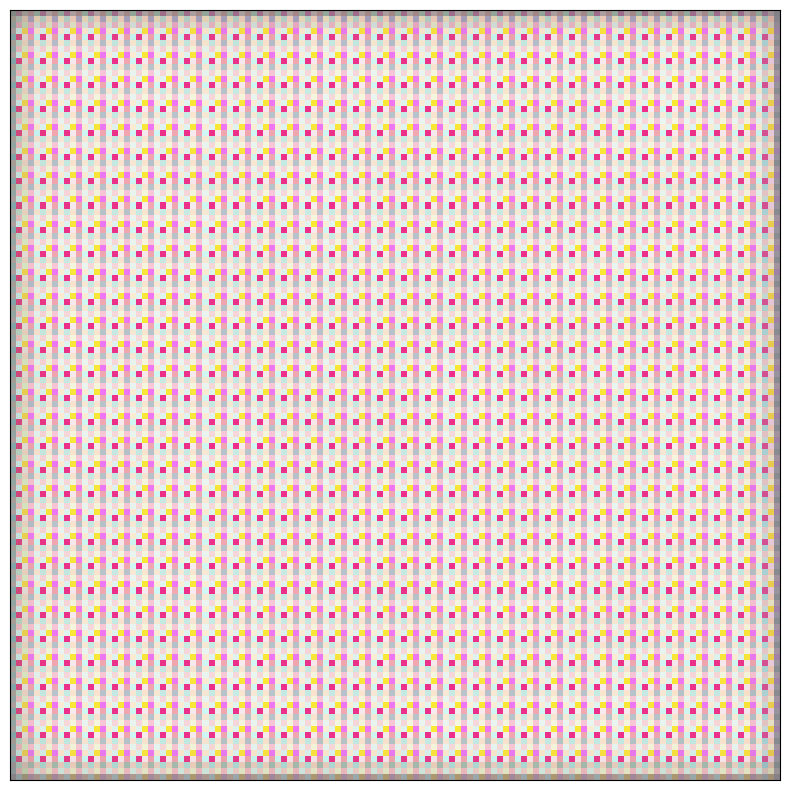

In [19]:
plot_generated_images(1)

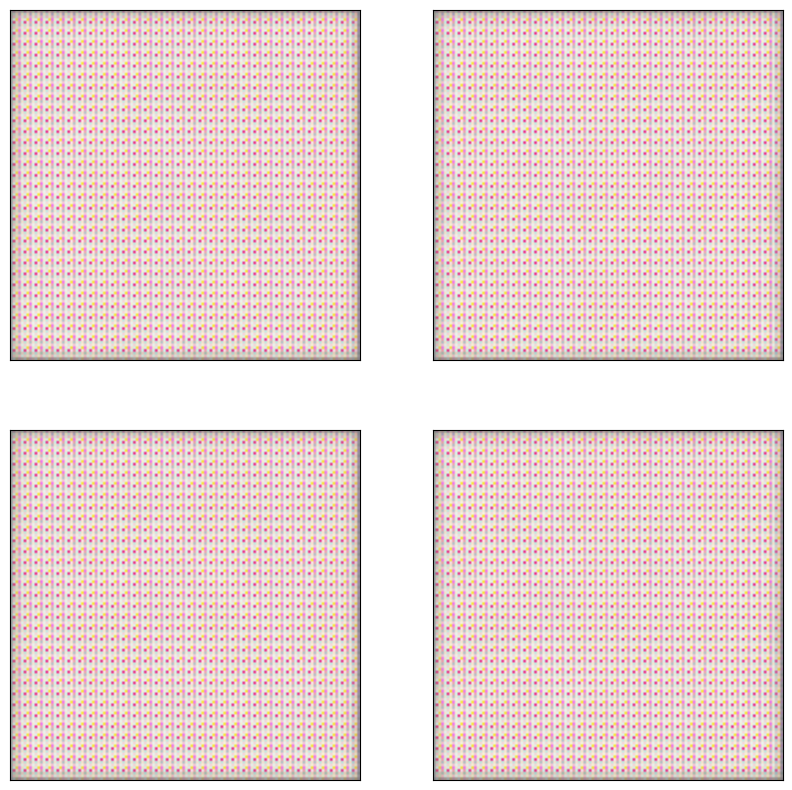

In [20]:
plot_generated_images(2)

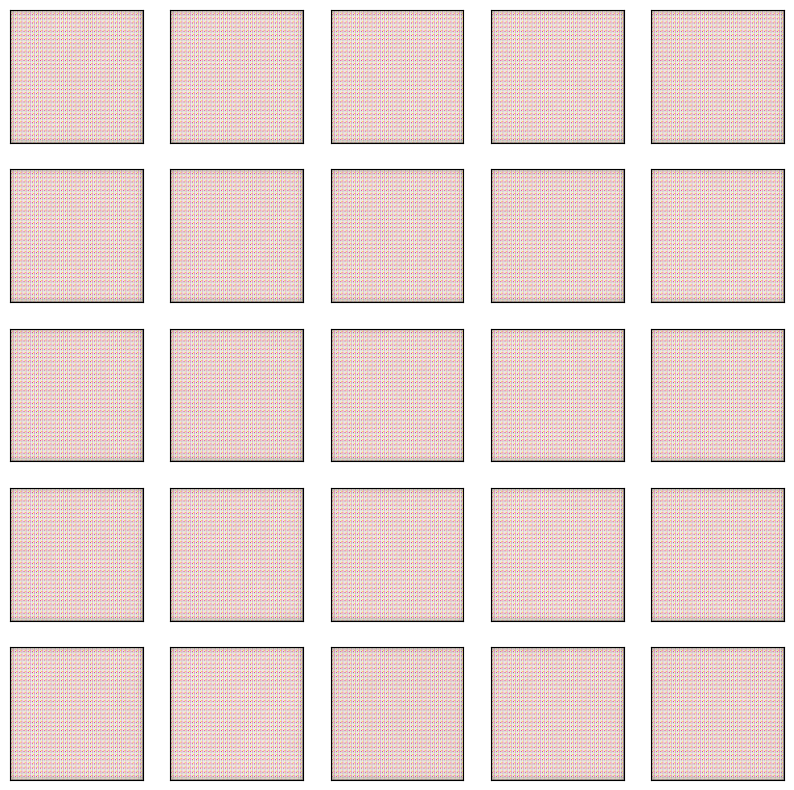

In [21]:
plot_generated_images(5)

In [ ]:
plot_generated_images(7)

In [ ]:
generator.save('generator.h5')
discriminator.save("discriminator.h5")